# Picture Classifier
This is the start of making the pictures model which will have 6 class

### Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , auc
from sklearn.model_selection import train_test_split

import cv2
#from google.colab.patches import cv2_imshow
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub

In [ ]:
import zipfile

local_zip = '/content/drive/MyDrive/model1pictures/dataset/Pictures.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

## Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/tmp/Pictures'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
#batch size dicubo pertama = 64
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 64,
                                                    class_mode = 'categorical',
                                                    target_size = (128, 128))

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size = 64,
                                                  class_mode = 'categorical',
                                                  target_size = (128,128))

Found 12000 images belonging to 6 classes.
Found 1200 images belonging to 6 classes.


## Model Architecture
We are using transfer learning with mobilenetv2 by using tensorflow-hub.

In [ ]:
class HubLayer(tf.keras.layers.Layer):
    def __init__(self, handle, **kwargs):
        self.handle = handle
        super(HubLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.hub_layer = hub.KerasLayer(self.handle, trainable=False)
        super(HubLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        return self.hub_layer(inputs)

    def get_config(self):
        config = super(HubLayer, self).get_config()
        config.update({"handle": self.handle})
        return config

In [ ]:
MODULE_HANDLE = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"
module = HubLayer(MODULE_HANDLE, input_shape=(128,128,3), trainable=False)

In [ ]:
num_class = 6

model = tf.keras.models.Sequential([
    module,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_class, activation='softmax'),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_layer (HubLayer)        (None, 1001)              1692489   
                                                                 
 dense (Dense)               (None, 512)               513024    
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 2208591 (8.43 MB)
Trainable params: 516102 (1.97 MB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________


## Training Dummy Model

For dummy model we only use 2 epochs

In [ ]:
history = model.fit(train_generator,
                    epochs = 2,
                    steps_per_epoch = 188,
                    validation_data = test_generator,
                    validation_steps = 19,)

Epoch 1/2
188/188 [==============================] - 123s 652ms/step - loss: 0.5502 - accuracy: 0.8593 - val_loss: 0.4058 - val_accuracy: 0.9025
Epoch 2/2
188/188 [==============================] - 119s 635ms/step - loss: 0.4413 - accuracy: 0.8830 - val_loss: 0.4286 - val_accuracy: 0.8950


In [ ]:
model.save('/content/drive/MyDrive/model1pictures/model/dummyModel.h5') #for 2 epochs

In [ ]:
model.save_weights('/content/drive/MyDrive/model1pictures/model/dummy_picture_model.h5') #for 2 epochs

In [ ]:
#model.load()

## Training Model

In [ ]:
from tensorflow.keras.callbacks import Callback

class ConvergenceChecker(Callback):
    def __init__(self, threshold=0.01):
        super(ConvergenceChecker, self).__init__()
        self.threshold = threshold
        self.prev_loss = None

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('loss')

        if self.prev_loss is not None:
            loss_difference = abs(current_loss - self.prev_loss)

            if loss_difference < self.threshold:
                print(f"\nModel has converged. Stopping training at epoch {epoch + 1}.")
                self.model.stop_training = True

        self.prev_loss = current_loss

In [ ]:
callback = ConvergenceChecker(0.001)

history = model.fit(train_generator,
                    epochs = 50,
                    steps_per_epoch = 188,
                    validation_data = test_generator,
                    validation_steps = 19,
                    callbacks=[callback])

Epoch 1/50
188/188 [==============================] - 117s 622ms/step - loss: 0.3373 - accuracy: 0.9142 - val_loss: 0.3600 - val_accuracy: 0.9125
Epoch 2/50
188/188 [==============================] - 139s 739ms/step - loss: 0.3302 - accuracy: 0.9183 - val_loss: 0.4234 - val_accuracy: 0.9000
Epoch 3/50
188/188 [==============================] - 128s 681ms/step - loss: 0.3276 - accuracy: 0.9179 - val_loss: 0.3962 - val_accuracy: 0.9033
Epoch 4/50
188/188 [==============================] - 129s 688ms/step - loss: 0.3291 - accuracy: 0.9168 - val_loss: 0.4033 - val_accuracy: 0.9033
Epoch 5/50
188/188 [==============================] - 120s 638ms/step - loss: 0.3323 - accuracy: 0.9166 - val_loss: 0.3533 - val_accuracy: 0.9150
Epoch 6/50
188/188 [==============================] - 119s 632ms/step - loss: 0.3265 - accuracy: 0.9206 - val_loss: 0.3695 - val_accuracy: 0.9125
Epoch 7/50
188/188 [==============================] - 119s 632ms/step - loss: 0.3223 - accuracy: 0.9212 - val_loss: 0.4601 -

### Plotting the Results

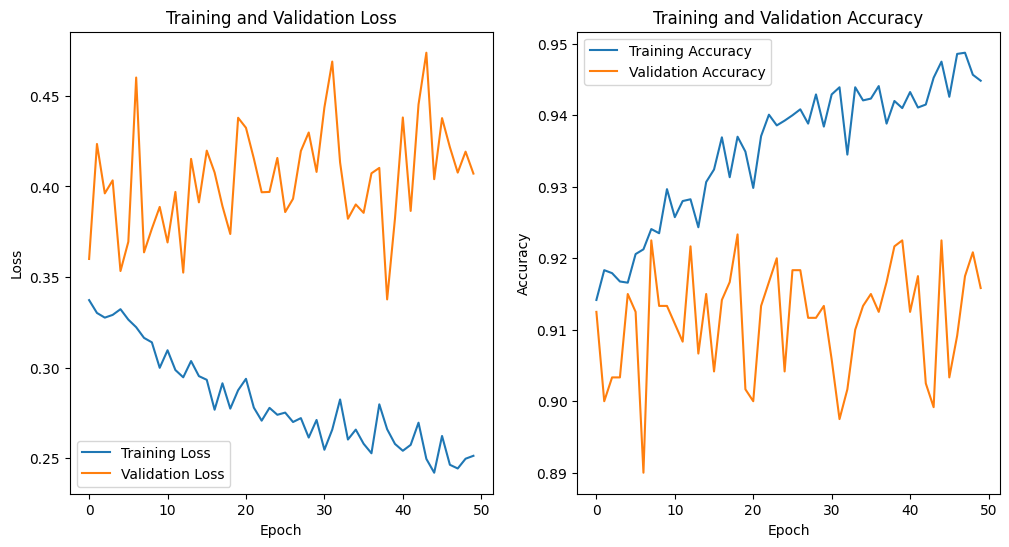

In [ ]:
# Extract training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract training and validation accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Saving model

In [ ]:
model.save('/content/drive/MyDrive/model1pictures/model/modeltype1.h5')
model.save_weights('/content/drive/MyDrive/model1pictures/model/modeltype1_weights.h5')

## Testing Predictions

In [ ]:
class HubLayer(tf.keras.layers.Layer):
    def __init__(self, handle, **kwargs):
        self.handle = handle
        super(HubLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.hub_layer = hub.KerasLayer(self.handle, trainable=False)
        super(HubLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        return self.hub_layer(inputs)

    def get_config(self):
        config = super(HubLayer, self).get_config()
        config.update({"handle": self.handle})
        return config

# Replace 'path/to/your/model.h5' with the actual path to your HDF5 model file
model_path = '/content/drive/MyDrive/model1pictures/model/modeltype1.h5'

# Define a custom object scope to tell TensorFlow about the custom layer
custom_objects = {'HubLayer': HubLayer}

# Load the model using the custom object scope
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model(model_path)

# Display the loaded model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_layer (HubLayer)        (None, 1001)              1692489   
                                                                 
 dense (Dense)               (None, 512)               513024    
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 2208591 (8.43 MB)
Trainable params: 516102 (1.97 MB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________


In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
def prepare_data_for_prediction(src):
  img = load_img(src, target_size=(128,128))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = preprocess_input(img_array)
  return img_array

label_array = ['Collage', 'Food', 'Friends', 'Memes', 'Pets', 'Selfie']

In [1]:
test_path = '/content/download.jpg'
prepare_img = prepare_data_for_prediction(test_path)

predictions = model.predict(prepare_img)
print('Predicted', label_array[np.argmax(predictions)])

NameError: ignored

In [ ]:
test_path = '/content/images.jpg'
prepare_img = prepare_data_for_prediction(test_path)

predictions = model.predict(prepare_img)
print('Predicted', label_array[np.argmax(predictions)])